<a href="https://colab.research.google.com/github/lazyrecluse/Spoon-Knife/blob/main/heatwave_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install basemap pymannkendall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 63.5 MB/s eta 0:00:00
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.7.0
    Uninstalling pyproj-3.7.0:
      Successfully uninstalled pyproj-3.7.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [ ]:
import pandas as pd
import numpy as np
file_path = '/content/drive/My Drive/final year project/datasets/processed_data.csv'
data= pd.read_csv(file_path)
data.head()

,time,latitude,longitude,stl1,stl2,tp,t2m
0,1993-01-04 12:00:00,15.0,2.00,-0.183133,0.311401,-3.493669e-09,-0.451446
1,1993-01-04 12:00:00,15.0,2.25,-0.206035,0.254718,-2.528946e-09,-0.466056
2,1993-01-04 12:00:00,15.0,2.50,-0.059944,0.741105,-4.818658e-09,-0.499284
3,1993-01-04 12:00:00,15.0,2.75,-0.156938,0.387921,-2.054248e-09,-0.462323
4,1993-01-04 12:00:00,15.0,3.00,-0.146687,0.546384,-3.524691e-09,-0.489209



Mann-Kendall Test Results:
--------------------------
Trend: increasing
Sen's slope: 0.0193°C/year
P-value: 0.0001
Tau: 0.5097
Significant (α=0.05): Yes


Mann_Kendall_Test(trend='increasing', h=True, p=6.042257609317758e-05, z=4.011154404076983, Tau=0.5096774193548387, s=237.0, var_s=3461.6666666666665, slope=0.019319898762369333, intercept=-0.26754829478842357)

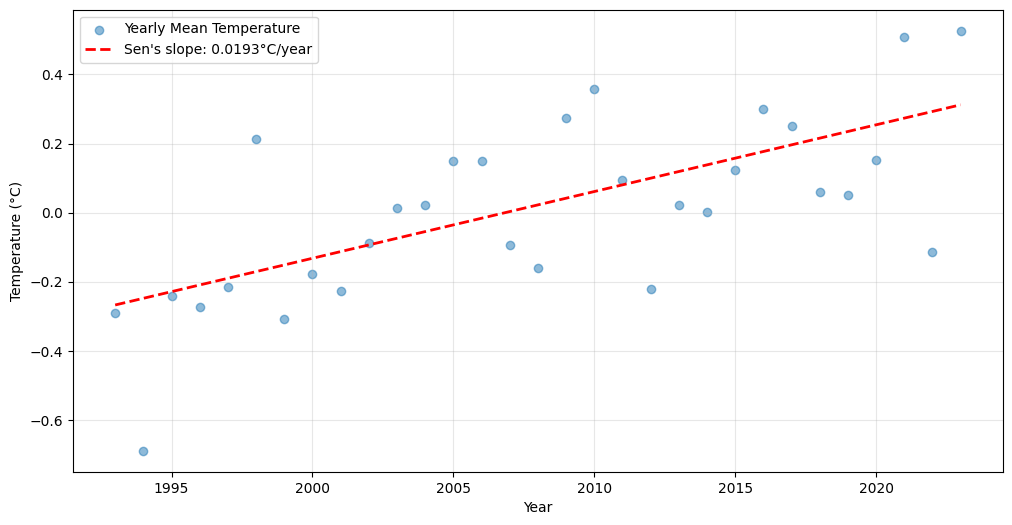

In [ ]:
import pandas as pd
import numpy as np
import pymannkendall as mk
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_yearly_trend(df, temp_column='t2m', date_column='date'):
    """
    Analyze yearly temperature trends using Mann-Kendall test and Sen's slope.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing detrended temperature data
    temp_column : str
        Name of the temperature column
    date_column : str
        Name of the date column
    """
    # Ensure date is datetime
    df = df.copy()
    df[date_column] = pd.to_datetime(df[date_column])

    # Calculate yearly means
    yearly_temp = df.groupby(df[date_column].dt.year)[temp_column].mean()

    # Perform Mann-Kendall test
    result = mk.original_test(yearly_temp)

    # Create visualization
    plt.figure(figsize=(12, 6))

    # Plot yearly temperatures
    years = yearly_temp.index
    plt.scatter(years, yearly_temp, alpha=0.5, label='Yearly Mean Temperature')

    # Plot Sen's slope
    if result.slope is not None:
        sen_line = result.slope * np.arange(len(years)) + result.intercept
        plt.plot(years, sen_line, 'r--',
                label=f"Sen's slope: {result.slope:.4f}°C/year",
                linewidth=2)


    plt.xlabel('Year')
    plt.ylabel('Temperature (°C)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Print results
    print("\nMann-Kendall Test Results:")
    print("--------------------------")
    print(f"Trend: {result.trend}")
    print(f"Sen's slope: {result.slope:.4f}°C/year")
    print(f"P-value: {result.p:.4f}")
    print(f"Tau: {result.Tau:.4f}")
    print(f"Significant (α=0.05): {'Yes' if result.p < 0.05 else 'No'}")

    return result
analyze_yearly_trend(data, temp_column='t2m', date_column='time')

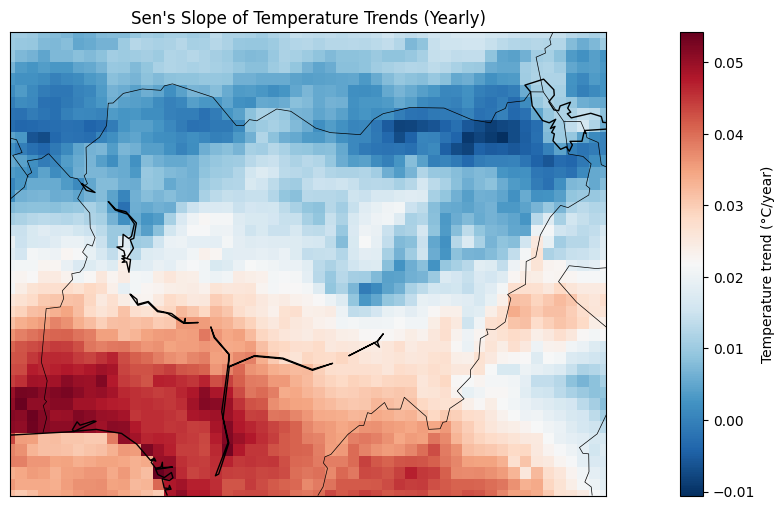

In [ ]:
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from scipy import stats
import pymannkendall as mk


# Convert data to a format suitable for analysis
# Assuming you want yearly trends, first calculate yearly means
data['year'] = pd.to_datetime(data['time']).dt.year
yearly_data = data.groupby(['year', 'latitude', 'longitude'])['t2m'].mean().reset_index()

# Create empty arrays to store results
lats = sorted(data['latitude'].unique())
lons = sorted(data['longitude'].unique())
mk_results = np.zeros((len(lats), len(lons)))
sens_slope = np.zeros((len(lats), len(lons)))

# Calculate Mann-Kendall test and Sen's slope for each grid point
for i, lat in enumerate(lats):
    for j, lon in enumerate(lons):
        temp_series = yearly_data[
            (yearly_data['latitude'] == lat) &
            (yearly_data['longitude'] == lon)
        ]['t2m'].values

        # Perform Mann-Kendall test
        mk_test = mk.original_test(temp_series)
        mk_results[i, j] = 1 if mk_test.p < 0.05 else 0  # 1 for significant trend

        # Calculate Sen's slope
        sens_slope[i, j] = mk_test.slope

# Create the map
plt.figure(figsize=(15, 10))
m = Basemap(projection='mill',
            llcrnrlat=min(lats), urcrnrlat=max(lats),
            llcrnrlon=min(lons), urcrnrlon=max(lons),
            resolution='l')

# Create mesh grid for plotting
lon_mesh, lat_mesh = np.meshgrid(lons, lats)
x, y = m(lon_mesh, lat_mesh)

# Plot Sen's slope
plt.subplot(211)
cs = m.pcolor(x, y, sens_slope, cmap='RdBu_r', shading='auto')
m.drawcoastlines()
m.drawcountries()
plt.colorbar(cs, label='Temperature trend (°C/year)')
plt.title("Sen's Slope of Temperature Trends (Yearly)")

# Plot significant trends (Mann-Kendall test results)
# plt.subplot(212)
# cs = m.pcolor(x, y, mk_results, cmap='binary', shading='auto')
# m.drawcoastlines()
# m.drawcountries()
# plt.colorbar(cs, label='Significant trend (1) / No significant trend (0)')
# plt.title('Significant Trends (p < 0.05) from Mann-Kendall Test')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import pymannkendall as mk
import matplotlib.pyplot as plt
import seaborn as sns

# # Create location strings for x-axis

data['location'] = data['longitude'].astype(str) + '°, ' + data['latitude'].astype(str) + '°'

# # Create the plot
# plt.figure(figsize=(15, 8))
# sns.violinplot(data=data, x='location', y='temperature')

# # Customize the plot
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('Location (Longitude°, Latitude°)')
# plt.ylabel('Temperature')
# plt.title('Temperature Distribution by Location')

# # Adjust layout to prevent label cutoff
# plt.tight_layout()

# # Show the plot
# plt.show()

# # Alternative approach using a swarm plot if you prefer to see individual points
# plt.figure(figsize=(15, 8))
# sns.swarmplot(data=data, x='location', y='temperature', size=3, alpha=0.6)
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('Location (Longitude°, Latitude°)')
# plt.ylabel('Temperature')
# plt.title('Temperature Distribution by Location (Swarm Plot)')
# plt.tight_layout()
# plt.show()

temp_avg = data.groupby('location')['t2m'].mean().reset_index()

# If you have too many points, you might want to use a box plot instead
plt.figure(figsize=(15, 8))
sns.boxplot(data=data, x='location', y='temp_avg')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Location (Longitude°, Latitude°)')
plt.ylabel('Temperature')
plt.title('Temperature Distribution by Location (Box Plot)')
plt.tight_layout()
plt.show()

ValueError: Could not interpret value `temp_avg` for `y`. An entry with this name does not appear in `data`.

<Figure size 1500x800 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pymannkendall as mk
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as colors

def calculate_spatial_trends(data, lat, lon):
    """
    Calculate Mann-Kendall trends for each grid point.

    Parameters:
    -----------
    data : numpy.ndarray
        3D array of temperature data (time, lat, lon)
    lat : numpy.ndarray
        Latitude values
    lon : numpy.ndarray
        Longitude values

    Returns:
    --------
    tuple
        Arrays of trend significance and Sen's slopes
    """
    trends = np.zeros((len(lat), len(lon)))
    slopes = np.zeros((len(lat), len(lon)))
    p_values = np.zeros((len(lat), len(lon)))

    for i in range(len(lat)):
        for j in range(len(lon)):
            # Get time series for this grid point
            temp_series = data[:, i, j]

            # Skip if all values are NaN
            if np.all(np.isnan(temp_series)):
                trends[i, j] = np.nan
                slopes[i, j] = np.nan
                p_values[i, j] = np.nan
                continue

            # Calculate Mann-Kendall test
            result = mk.original_test(temp_series)

            # Store results
            slopes[i, j] = result.slope if result.slope is not None else np.nan
            p_values[i, j] = result.p

            # Determine trend significance and direction
            if result.p < 0.05:
                trends[i, j] = 1 if result.slope > 0 else -1
            else:
                trends[i, j] = 0

    return trends, slopes, p_values

def plot_spatial_trends(lat, lon, trends, slopes, p_values,
                       region=None, title='Temperature Trends'):
    """
    Create maps of trend significance and Sen's slopes.

    Parameters:
    -----------
    lat : numpy.ndarray
        Latitude values
    lon : numpy.ndarray
        Longitude values
    trends : numpy.ndarray
        Array of trend significance values
    slopes : numpy.ndarray
        Array of Sen's slopes
    p_values : numpy.ndarray
        Array of p-values
    region : tuple, optional
        (min_lat, max_lat, min_lon, max_lon) for map region
    title : str
        Title for the plots
    """
    fig = plt.figure(figsize=(15, 10))

    # Set up map region
    if region is None:
        min_lat, max_lat = lat.min(), lat.max()
        min_lon, max_lon = lon.min(), lon.max()
    else:
        min_lat, max_lat, min_lon, max_lon = region

    # Create subplots
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)

    # Set up colormaps
    trend_colors = ['blue', 'white', 'red']
    trend_bounds = [-1.5, -0.5, 0.5, 1.5]
    trend_norm = BoundaryNorm(trend_bounds, len(trend_colors))

    # Create maps
    for ax, data, label, cmap in zip(
        [ax1, ax2],
        [trends, slopes],
        ['Trend Significance', "Sen's Slope"],
        [colors.ListedColormap(trend_colors), 'RdBu_r']
    ):
        m = Basemap(projection='mill',
                   llcrnrlat=min_lat, urcrnrlat=max_lat,
                   llcrnrlon=min_lon, urcrnrlon=max_lon,
                   ax=ax)

        # Draw map features
        m.drawcoastlines()
        m.drawcountries()
        m.drawparallels(np.arange(-90., 90., 30.), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])

        # Convert lat/lon to map coordinates
        lon_mesh, lat_mesh = np.meshgrid(lon, lat)
        x, y = m(lon_mesh, lat_mesh)

        # Plot data
        if label == 'Trend Significance':
            cs = m.pcolor(x, y, data, cmap=cmap, norm=trend_norm)
            cbar_label = 'Trend Direction (Blue: Negative, Red: Positive)'
        else:
            cs = m.pcolor(x, y, data, cmap=cmap)
            cbar_label = 'Temperature Change per Year (°C/year)'

        # Add colorbar
        cbar = m.colorbar(cs, location='bottom', pad='10%')
        cbar.set_label(cbar_label)

        # Add title
        ax.set_title(f'{label}')

    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()


    # Calculate trends

lat =
lon = lon.values
trends, slopes, p_values = calculate_spatial_trends(data, lat, lon)

    # Plot results
plot_spatial_trends(lat, lon, trends, slopes, p_values,
                       title='Temperature Trends')
plt.show()

SyntaxError: invalid syntax (<ipython-input-11-7a89471a184d>, line 141)

In [ ]:
def mask_dry_season(data, date_column='time'):
    """
    Creates a mask for selecting only the dry season (Nov to April).

    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing temperature data
    date_column : str
        Name of the column containing datetime information

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing only dry season data
    """
    # Ensure the date column is datetime type
    if not pd.api.types.is_datetime64_any_dtype(data[date_column]):
        data[date_column] = pd.to_datetime(data[date_column])

    # Extract months from the date column
    months = data[date_column].dt.month

    # Create mask for dry season months (Nov to April)
    dry_season_mask = months.isin([11, 12, 1, 2, 3, 4])

    # Return filtered DataFrame
    return data[dry_season_mask]


In [ ]:
d = mask_dry_season(data)
d.head()

,time,latitude,longitude,stl1,stl2,tp,t2m
0,1993-01-04 12:00:00,15.0,2.00,-0.183133,0.311401,-3.493669e-09,-0.451446
1,1993-01-04 12:00:00,15.0,2.25,-0.206035,0.254718,-2.528946e-09,-0.466056
2,1993-01-04 12:00:00,15.0,2.50,-0.059944,0.741105,-4.818658e-09,-0.499284
3,1993-01-04 12:00:00,15.0,2.75,-0.156938,0.387921,-2.054248e-09,-0.462323
4,1993-01-04 12:00:00,15.0,3.00,-0.146687,0.546384,-3.524691e-09,-0.489209


In [ ]:
def create_lagged_features(df, predictors, lags=[3, 5, 7]):
    """
    Creates lagged features for the specified predictors by the given lag days.
    Drops rows with NaN values created by the shift.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the temperature data.
    predictors : list of str
        The column names of predictors to lag (e.g., 't2m').
    lags : list of int
        The list of lag days to apply (e.g., [3, 5, 7]).

    Returns:
    --------
    new_df: pandas DataFrame with lagged features.
    """
    new_df = df.copy()
    new_df['date'] =  pd.to_datetime(new_df['time'])

    # Lag each predictor by the specified days
    for predictor in predictors:
        for lag in lags:
            new_df[f'{predictor}_lag_{lag}'] = new_df[predictor].shift(-lag)

    # Drop rows with NaN values due to the shift
    new_df.dropna(inplace=True)

    return new_df

def prepare_data_for_heatwave_prediction(data, temp_column='t2m', lags=[3, 5, 7]):
    """
    Prepares the data for heatwave magnitude prediction by creating lagged features
    and calculating the 3-day rolling mean as the target variable.

    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing temperature data and other predictors.
    temp_column : str
        Name of the column containing temperature values.
    lags : list of int
        The list of lag days to apply for the lagged features.

    Returns:
    --------
    X: pandas.DataFrame
        Feature matrix with lagged features.
    y: pandas.Series
        The target variable (3-day rolling mean temperature).
    """
    # Create lagged features for temperature
    df_lagged = create_lagged_features(data, [temp_column], lags)

    # Calculate the 3-day rolling mean as the target
    df_lagged['t2m_rolling_mean'] = df_lagged[temp_column].rolling(window=3, center=True).mean()

    # Drop rows with NaN values (from rolling mean)
    df_lagged.dropna(inplace=True)

    # Define X (lagged features) and y (rolling mean temperature)
    X = df_lagged.drop(columns=['t2m_rolling_mean'])
    y = df_lagged['t2m_rolling_mean']

    return X, y

In [ ]:
new_df =  create_lagged_features(d, ['t2m', 'stl1','stl2','tp'], lags=[3, 5, 7])
new_df.head()

,time,latitude,longitude,stl1,stl2,tp,t2m,date,t2m_lag_3,t2m_lag_5,t2m_lag_7,stl1_lag_3,stl1_lag_5,stl1_lag_7,stl2_lag_3,stl2_lag_5,stl2_lag_7,tp_lag_3,tp_lag_5,tp_lag_7
0,1993-01-04 12:00:00,15.0,2.00,-0.183133,0.311401,-3.493669e-09,-0.451446,1993-01-04 12:00:00,-0.462323,-0.504896,-0.514001,-0.156938,-0.118383,-0.216821,0.387921,0.627231,0.326741,-2.054248e-09,-4.141776e-02,-2.361294e-09
1,1993-01-04 12:00:00,15.0,2.25,-0.206035,0.254718,-2.528946e-09,-0.466056,1993-01-04 12:00:00,-0.489209,-0.499278,-0.566177,-0.146687,-0.191727,-0.115735,0.546384,0.378511,0.665284,-3.524691e-09,-4.141684e-02,-3.139140e-09
2,1993-01-04 12:00:00,15.0,2.50,-0.059944,0.741105,-4.818658e-09,-0.499284,1993-01-04 12:00:00,-0.504896,-0.514001,-0.603409,-0.118383,-0.216821,-0.199379,0.627231,0.326741,0.497253,-4.141776e-02,-2.361294e-09,-3.955436e-09
3,1993-01-04 12:00:00,15.0,2.75,-0.156938,0.387921,-2.054248e-09,-0.462323,1993-01-04 12:00:00,-0.499278,-0.566177,-0.628536,-0.191727,-0.115735,-0.201655,0.378511,0.665284,0.448677,-4.141684e-02,-3.139140e-09,-6.757035e-09
4,1993-01-04 12:00:00,15.0,3.00,-0.146687,0.546384,-3.524691e-09,-0.489209,1993-01-04 12:00:00,-0.514001,-0.603409,-0.657597,-0.216821,-0.199379,-0.315641,0.326741,0.497253,0.249974,-2.361294e-09,-3.955436e-09,-2.387819e-09


In [ ]:
X, y = prepare_data_for_heatwave_prediction(new_df, temp_column='t2m', lags=[3, 5, 7])
X.head()

,time,latitude,longitude,stl1,stl2,tp,t2m,date,t2m_lag_3,t2m_lag_5,t2m_lag_7,stl1_lag_3,stl1_lag_5,stl1_lag_7,stl2_lag_3,stl2_lag_5,stl2_lag_7,tp_lag_3,tp_lag_5,tp_lag_7
1,1993-01-04 12:00:00,15.0,2.25,-0.206035,0.254718,-2.528946e-09,-0.466056,1993-01-04 12:00:00,-0.489209,-0.499278,-0.566177,-0.146687,-0.191727,-0.115735,0.546384,0.378511,0.665284,-3.524691e-09,-4.141684e-02,-3.139140e-09
2,1993-01-04 12:00:00,15.0,2.50,-0.059944,0.741105,-4.818658e-09,-0.499284,1993-01-04 12:00:00,-0.504896,-0.514001,-0.603409,-0.118383,-0.216821,-0.199379,0.627231,0.326741,0.497253,-4.141776e-02,-2.361294e-09,-3.955436e-09
3,1993-01-04 12:00:00,15.0,2.75,-0.156938,0.387921,-2.054248e-09,-0.462323,1993-01-04 12:00:00,-0.499278,-0.566177,-0.628536,-0.191727,-0.115735,-0.201655,0.378511,0.665284,0.448677,-4.141684e-02,-3.139140e-09,-6.757035e-09
4,1993-01-04 12:00:00,15.0,3.00,-0.146687,0.546384,-3.524691e-09,-0.489209,1993-01-04 12:00:00,-0.514001,-0.603409,-0.657597,-0.216821,-0.199379,-0.315641,0.326741,0.497253,0.249974,-2.361294e-09,-3.955436e-09,-2.387819e-09
5,1993-01-04 12:00:00,15.0,3.25,-0.118383,0.627231,-4.141776e-02,-0.504896,1993-01-04 12:00:00,-0.566177,-0.628536,-0.669155,-0.115735,-0.201655,-0.299576,0.665284,0.448677,0.250472,-3.139140e-09,-6.757035e-09,-5.777979e-09


In [ ]:
y.head()

,t2m_rolling_mean
1,-0.472262
2,-0.475888
3,-0.483605
4,-0.485476
5,-0.497794


In [ ]:
X = X.drop(columns=['time', 'longitude', 'latitude', 't2m', 'stl1', 'stl2', 'tp'])
X.head()

,t2m_lag_3,t2m_lag_5,t2m_lag_7,stl1_lag_3,stl1_lag_5,stl1_lag_7,stl2_lag_3,stl2_lag_5,stl2_lag_7,tp_lag_3,tp_lag_5,tp_lag_7
1,-0.489209,-0.499278,-0.566177,-0.146687,-0.191727,-0.115735,0.546384,0.378511,0.665284,-3.524691e-09,-4.141684e-02,-3.139140e-09
2,-0.504896,-0.514001,-0.603409,-0.118383,-0.216821,-0.199379,0.627231,0.326741,0.497253,-4.141776e-02,-2.361294e-09,-3.955436e-09
3,-0.499278,-0.566177,-0.628536,-0.191727,-0.115735,-0.201655,0.378511,0.665284,0.448677,-4.141684e-02,-3.139140e-09,-6.757035e-09
4,-0.514001,-0.603409,-0.657597,-0.216821,-0.199379,-0.315641,0.326741,0.497253,0.249974,-2.361294e-09,-3.955436e-09,-2.387819e-09
5,-0.566177,-0.628536,-0.669155,-0.115735,-0.201655,-0.299576,0.665284,0.448677,0.250472,-3.139140e-09,-6.757035e-09,-5.777979e-09


In [ ]:
y.head()

,t2m_rolling_mean
1,-0.472262
2,-0.475888
3,-0.483605
4,-0.485476
5,-0.497794


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def train_and_evaluate_timeseries_model(X, y, train_years=20, test_years=10):
    """
    Trains and evaluates a Ridge Regression model for heatwave prediction on time series data.
    Splits the data by indexing the first 20 years for training and the last 10 years for testing.

    Parameters:
    -----------
    X : pandas.DataFrame
        The feature matrix (lagged features).
    y : pandas.Series
        The target variable (3-day rolling mean temperature).
    train_years : int
        Number of years to use for training.
    test_years : int
        Number of years to use for testing.

    Returns:
    --------
    model : Trained Ridge Regression model.
    performance : Dictionary of performance metrics (MAE, MSE) on the test set.
    """
    # Split the data based on the index (assumed to be chronological time index)
    train_size = train_years / (train_years + test_years)

    # Index split based on the size (first 20 years for training, last 10 for testing)
    train_size_index = int(len(X) * train_size)

    X_train, X_test = X[:train_size_index], X[train_size_index:]
    y_train, y_test = y[:train_size_index], y[train_size_index:]

    # Define the model (Ridge Regression) and parameter grid for GridSearchCV
    ridge = Ridge()
    param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}  # Grid of alpha values

    # GridSearchCV for hyperparameter tuning on the training data
    grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Predict on the test set (last 10 years)
    y_pred = best_model.predict(X_test)

    # Evaluate the performance on the test set
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    performance = {'MAE': mae, 'MSE': mse, 'MAPE': mape}
    print(f"Best Alpha: {grid_search.best_params_['alpha']}")
    print(f"Mean Absolute Error (Test): {mae:.4f}")
    print(f"Mean Squared Error (Test): {mse:.4f}")
    print(f"Mean Absolute Percentage Error (Test): {mape:.4f}")

    return best_model, performance, y_test, y_pred, X_test

# Example usage:
# Assuming 'X' is your feature matrix and 'y' is the target (rolling mean temperature)
best_model, performance, y_test, y_pred, X_test = train_and_evaluate_timeseries_model(X, y, train_years=20, test_years=10)


Best Alpha: 0.01
Mean Absolute Error (Test): 0.2348
Mean Squared Error (Test): 0.1276
Mean Absolute Percentage Error (Test): 2.6133


In [ ]:
best_model.coef_

array([ 9.76725043e-01, -7.22593809e-02,  3.50684180e-02, -8.98417717e-02,
        1.18119637e-02,  3.63088715e-02,  3.69954935e-02,  5.40346462e-03,
       -3.74468916e-03, -3.02047635e-07, -1.37200705e-07,  1.25801516e-07])

In [ ]:
def view_model_coefficients(model, feature_names):
    """
    Prints the coefficients of the trained Ridge Regression model along with their corresponding feature names.

    Parameters:
    -----------
    model : Ridge or other linear model
        The trained Ridge Regression model.
    feature_names : list of str
        The list of feature names used for training.

    Returns:
    --------
    None
    """
    # Get the model coefficients
    coefficients = model.coef_

    # Zip the feature names and coefficients together
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', ascending=False)

    # Display the feature importance
    print(coef_df)


# Example usage:
# Assuming you have trained the model and have the feature names
feature_names = X_test.columns  # Or a list of feature names
view_model_coefficients(best_model, feature_names)


       Feature   Coefficient
0    t2m_lag_3  9.767250e-01
6   stl2_lag_3  3.699549e-02
5   stl1_lag_7  3.630887e-02
2    t2m_lag_7  3.506842e-02
4   stl1_lag_5  1.181196e-02
7   stl2_lag_5  5.403465e-03
11    tp_lag_7  1.258015e-07
10    tp_lag_5 -1.372007e-07
9     tp_lag_3 -3.020476e-07
8   stl2_lag_7 -3.744689e-03
1    t2m_lag_5 -7.225938e-02
3   stl1_lag_3 -8.984177e-02


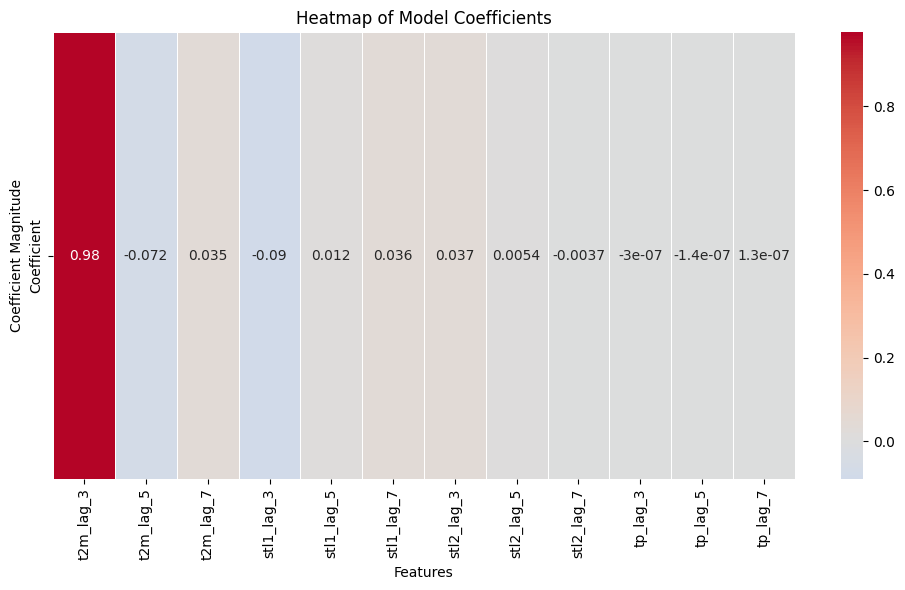

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_coefficients_heatmap(model, feature_names):
    """
    Plots a heatmap of the coefficients from the trained Ridge Regression model.

    Parameters:
    -----------
    model : Ridge or other linear model
        The trained Ridge Regression model.
    feature_names : list of str
        The list of feature names used for training.

    Returns:
    --------
    None
    """
    # Get the model coefficients
    coefficients = model.coef_

    # Create a DataFrame for feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).set_index('Feature')

    # Plot heatmap
    plt.figure(figsize=(10, 6))

    # Using seaborn heatmap to plot the coefficients
    sns.heatmap(coef_df.T, annot=True, cmap='coolwarm', cbar=True, center=0, linewidths=0.5)

    # Set plot title and labels
    plt.title('Heatmap of Model Coefficients')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Magnitude')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'best_model' is your trained Ridge model and 'feature_names' is a list of feature names
plot_coefficients_heatmap(best_model, feature_names)


In [ ]:
X_test.index

Index([16126547, 16126548, 16126549, 16126550, 16126551, 16126552, 16126553,
       16126554, 16126555, 16126556,
       ...
       24589643, 24589644, 24589645, 24589646, 24589647, 24589648, 24589649,
       24589650, 24589651, 24589652],
      dtype='int64', length=4064954)

In [ ]:

y_30 = y_pred[:30]
y_30

array([-0.43864482, -0.33232921, -0.47573784, -0.29438343, -0.25713963,
       -0.40645017, -0.53568414, -0.51040901, -0.31558274, -0.09888453,
       -0.10964252,  0.02286909,  0.08713641,  0.09168236,  0.0419251 ,
       -0.04490151, -0.14410234, -0.30022915, -0.36158888, -0.23213255,
       -0.18223267, -0.1054536 , -0.10938428, -0.14247912, -0.26915152,
       -0.51837397, -0.5108391 , -0.84870229, -0.97976634, -0.84495811])

In [ ]:
y_2 = y_test[:30]
y_2.shape

(30,)

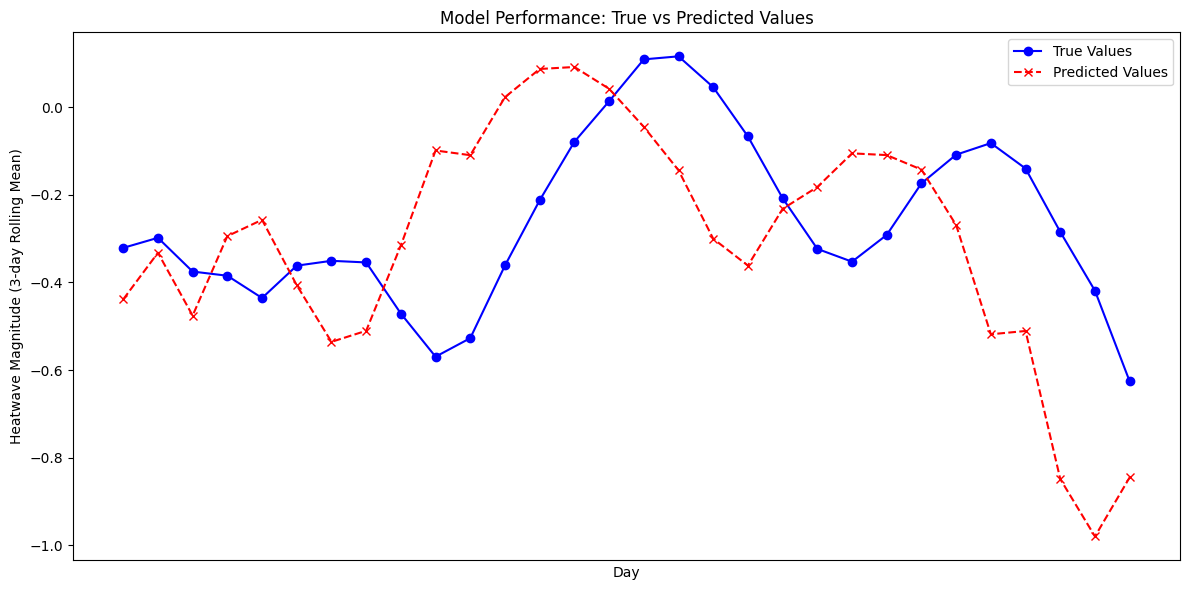

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_subsampled_performance(y_test, y_pred, time_index, step=10000):
    """
    Plots the true vs. predicted values of the model over time, with subsampling to reduce overcrowding.

    Parameters:
    -----------
    y_test : pandas.Series or numpy.ndarray
        The true values of the target variable (e.g., rolling mean temperature).
    y_pred : pandas.Series or numpy.ndarray
        The predicted values from the model.
    time_index : pandas.Index or array-like
        The time index or date range corresponding to y_test and y_pred.
    step : int
        The step size for subsampling (e.g., plot every 10th data point).

    Returns:
    --------
    None
    """
    # Convert the time index to a DatetimeIndex if necessary
    time_index = pd.to_datetime(time_index)

    # Ensure time_index and y_test/y_pred have the same length
    time_index = time_index[:len(y_test)]  # Subset time_index to match y_test/y_pred length


    # Plot the subsampled data
    plt.figure(figsize=(12, 6))

    # Plot true values
    plt.plot(time_index, y_test, label='True Values', color='blue', linestyle='-', marker='o')

    # Plot predicted values
    plt.plot(time_index, y_pred, label='Predicted Values', color='red', linestyle='--', marker='x')

    # Add titles and labels
    plt.title('Model Performance: True vs Predicted Values')
    plt.xlabel('Day')
    plt.ylabel('Heatwave Magnitude (3-day Rolling Mean)')

    # Add a legend
    plt.legend()

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage:
# Plot every 10th data point to reduce overcrowding
plot_subsampled_performance(y_2, y_30, X_test.index, '''step=100000''')

In [ ]:
mask

array([False, False, False, ..., False, False, False])

In [ ]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Function to train and evaluate Ridge Regression in a memory-efficient way
def train_ridge_magnitude_model(X, y, alpha=0.1):
    """
    Trains a Ridge Regression model using TimeSeriesSplit in a memory-efficient way.

    Parameters:
    - X: Feature matrix (predictors)
    - y: Target variable (heatwave magnitude)
    - alpha: Regularization strength for Ridge Regression

    Returns:
    - all_y_true_train: Array of true target values for training set across all splits
    - all_y_pred_train: Array of predicted target values for training set across all splits
    - all_y_true_test: Array of true target values for testing set across all splits
    - all_y_pred_test: Array of predicted target values for testing set across all splits
    """
    tscv = TimeSeriesSplit(n_splits=5)  # TimeSeriesSplit for cross-validation
    model = Ridge(alpha=alpha)  # Initialize Ridge Regression model

    all_y_true_train = []
    all_y_pred_train = []
    all_y_true_test = []
    all_y_pred_test = []

    for train_index, test_index in tscv.split(X):
        # Split the data into training and testing sets (memory efficient)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the Ridge Regression model on the training set
        model.fit(X_train, y_train)

        # Predict the heatwave magnitude on both the training and test sets
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Store the true and predicted values for evaluation
        all_y_true_train.extend(y_train)
        all_y_pred_train.extend(y_pred_train)
        all_y_true_test.extend(y_test)
        all_y_pred_test.extend(y_pred_test)

    return (np.array(all_y_true_train), np.array(all_y_pred_train),
            np.array(all_y_true_test), np.array(all_y_pred_test))


def evaluate_model_performance(y_true_train, y_pred_train, y_true_test, y_pred_test):
    """
    Evaluates the model performance using RMSE, MAE, and MAPE on both training and test sets.

    Parameters:
    - y_true_train: Array of true values for training set
    - y_pred_train: Array of predicted values for training set
    - y_true_test: Array of true values for testing set
    - y_pred_test: Array of predicted values for testing set

    Returns:
    - A dictionary with metrics for both training and test sets (RMSE, MAE, MAPE)
    """
    print("Training Set Performance:")
    print("--------------------------")
    rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
    mae_train = mean_absolute_error(y_true_train, y_pred_train)
    mape_train = mean_absolute_percentage_error(y_true_train, y_pred_train)
    print(f"RMSE (Train): {rmse_train:.4f}")
    print(f"MAE (Train): {mae_train:.4f}")
    print(f"MAPE (Train): {mape_train:.4f}\n")

    print("Test Set Performance:")
    print("----------------------")
    rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
    mae_test = mean_absolute_error(y_true_test, y_pred_test)
    mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test)
    print(f"RMSE (Test): {rmse_test:.4f}")
    print(f"MAE (Test): {mae_test:.4f}")
    print(f"MAPE (Test): {mape_test:.4f}")

    # Return a dictionary of performance metrics
    return {
        'train': {'RMSE': rmse_train, 'MAE': mae_train, 'MAPE': mape_train},
        'test': {'RMSE': rmse_test, 'MAE': mae_test, 'MAPE': mape_test}
    }

# Example usage:
# Assuming you have X (features) and y (target variable)

In [ ]:
import pandas as pd
import pingouin as pg  # For partial correlation

def calculate_partial_rank_correlation_with_heatwave(features, heatwave):
    """
    Computes partial rank correlation between each feature and the heatwave occurrence, controlling for other features.

    Parameters:
    - features: A DataFrame containing the features (e.g., 't2m', 'tp', 'stl1', 'stl2')
    - heatwave: A pandas Series containing the binary heatwave occurrence (1 for heatwave, 0 for non-heatwave)

    Returns:
    - correlation_results: DataFrame containing partial rank correlations for each feature
    """
    # Ensure heatwave occurrence is added to the DataFrame
    data = features.copy()
    data['heatwave'] = heatwave.astype(int)  # Convert boolean to integers (1 for True, 0 for False)

    # Compute partial rank correlations
    correlation_results = []
    for feature in features.columns:
        # Control for all other features
        control_vars = features.columns.difference([feature]).tolist()

        # Calculate partial rank correlation for the current feature, controlling for others
        corr = pg.partial_corr(data=data, x=feature, y='heatwave', covar=control_vars, method='spearman')
        correlation_results.append(corr)

    return pd.concat(correlation_results)

# Example usage:
# Assuming 'features' is a DataFrame with columns ['t2m', 'tp', 'stl1', 'stl2']
# and 'heatwave' is the result of the classify_heatwaves function (boolean Series)

# Calculate partial rank correlations
correlation_results = calculate_partial_rank_correlation_with_heatwave(d[['stl1', 'stl2', 'tp', 't2m']], heatwave['t2m'])

# Display the results
print(correlation_results)


                n         r           CI95%         p-val
spearman  6162628  0.002411      [0.0, 0.0]  2.147032e-09
spearman  6162628 -0.007075  [-0.01, -0.01]  4.681422e-69
spearman  6162628 -0.004170    [-0.0, -0.0]  4.111442e-25
spearman  6162628  0.024080    [0.02, 0.02]  0.000000e+00


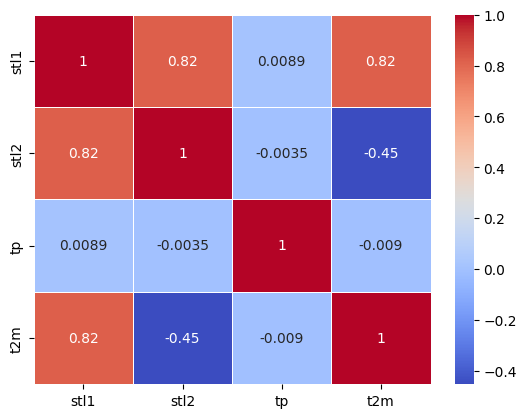

In [ ]:
p_corr = d[['stl1','stl2','tp','t2m']].pcorr()
sns.heatmap(p_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

<ipython-input-14-ee53d40166c8>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features, y=correlations, palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


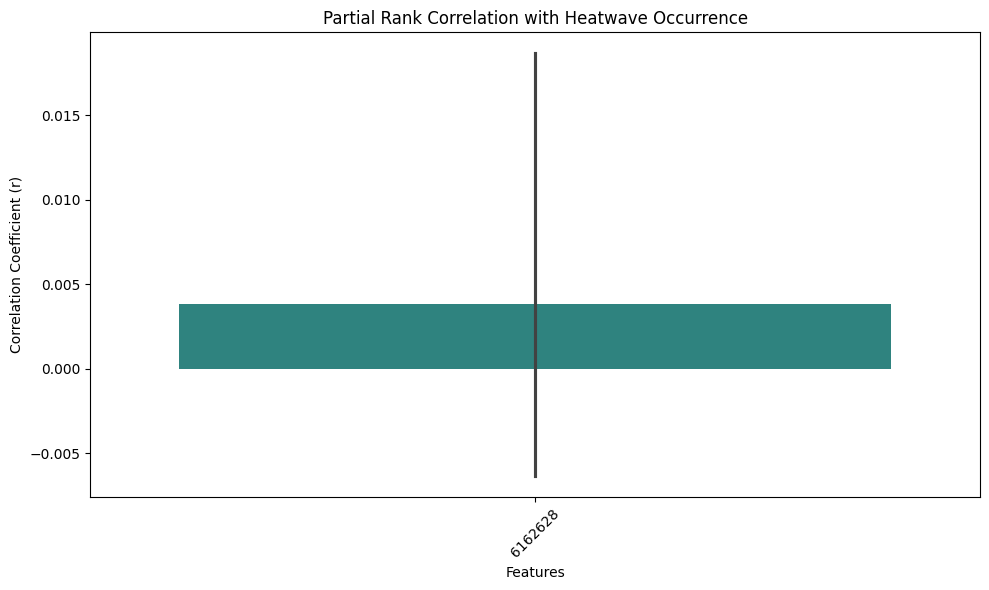

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_partial_correlation_results(correlation_results):
    """
    Plots the partial rank correlation results as a bar plot.

    Parameters:
    - correlation_results: DataFrame containing partial correlation results

    The function creates a bar plot showing the correlation coefficients (r) for each feature.
    """
    # Extract the feature names and correlation values (r)
    features = correlation_results['n']  # Column 'x' contains the feature names
    correlations = correlation_results['r']  # Column 'r' contains the Spearman correlation coefficients

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=features, y=correlations, palette='viridis')

    # Add titles and labels
    plt.title('Partial Rank Correlation with Heatwave Occurrence')
    plt.xlabel('Features')
    plt.ylabel('Correlation Coefficient (r)')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming correlation_results is the DataFrame from the partial correlation calculations
plot_partial_correlation_results(correlation_results)


In [ ]:
y_true,y_pred = train_ridge_magnitude_model(X, y)

In [ ]:
X.shape, y_pred.shape

((12194876, 4), (10162395,))

In [ ]:
rmse = evaluate_model_performance(y_true, y_pred)
rmse

Root Mean Squared Error (RMSE): 0.0912
Mean Absolute Error (MAE): 0.0494
Mean Absolute Percentage Error (MAPE): 0.9433


(0.0912281196227128, 0.04941905881705679, 0.9432779855945143)

In [ ]:
# Calculate the relative RMSE as a percentage of the mean of the target
relative_rmse = (rmse / np.mean(y_true)) * 100
print(f"Relative RMSE: {relative_rmse:.2f}%")


Relative RMSE: 81.71%


In [ ]:
import xarray as xr
import numpy as np
file_path = '/content/drive/My Drive/final year project/datasets/processed_data.nc'
data= xr.open_dataset(file_path)
data

<xarray.Dataset> Size: 394MB
Dimensions:    (time: 11316, latitude: 41, longitude: 53)
Coordinates:
  * time       (time) datetime64[ns] 91kB 1993-01-04T12:00:00 ... 2023-12-28T...
  * longitude  (longitude) float32 212B 2.0 2.25 2.5 2.75 ... 14.5 14.75 15.0
  * latitude   (latitude) float32 164B 15.0 14.75 14.5 14.25 ... 5.5 5.25 5.0
Data variables:
    stl1       (time, latitude, longitude) float32 98MB ...
    stl2       (time, latitude, longitude) float32 98MB ...
    tp         (time, latitude, longitude) float32 98MB ...
    t2m        (time, latitude, longitude) float32 98MB ...

In [ ]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 60.0 MB/s eta 0:00:00
